In [1]:
import time
from tqdm import tqdm
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
from gensim.models import Word2Vec
from keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
import os
from keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# Load the data
df = pd.read_csv('Data/train_essays/train_essays.csv')

# Display the data
df

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [3]:
# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Drop the last column from the test data
test_df = test_df.iloc[:, :-1]

# Create a directory to save the temporary data
os.makedirs('Data/temporary', exist_ok=True)

# Save the training and testing data
train_df.to_csv('Data/temporary/Temp_Train_Data.csv', index=False)
test_df.to_csv('Data/temporary/Temp_Test_Data.csv', index=False)

In [4]:
# Load the training and testing data
train_df = pd.read_csv('Data/temporary/Temp_Train_Data.csv')
test_df = pd.read_csv('Data/temporary/Temp_Test_Data.csv')


In [5]:
# Display the training data
train_df

,id,prompt_id,text,generated
0,e0dbb2e7,0,"Cars, they make life so much easier, or, do th...",0
1,3d75a33b,0,Now a days you see everyone with cars driving ...,0
2,6049a24f,1,Presidential election is held every after four...,0
3,cecf6e5e,1,I dont think that the electoral college should...,0
4,669e6f61,0,How could we get the reduction of Greenhouse G...,0
...,...,...,...,...
1097,c7c1cf69,0,People all over the world are saying goodbye t...,0
1098,cf8af518,1,"Dear state senator, I believe that we shouldn'...",0
1099,f01dd0a6,0,The modern automobile has been the axle to the...,0
1100,9b753df1,1,The Electoral College is a process that should...,0


In [6]:
# Display the testing data
test_df

,id,prompt_id,text
0,70d7c567,0,Can you imagine living in a place where there ...
1,81977e6c,0,Limiting car usage could have many advantages ...
2,e43869b8,0,"In this generation, our planet is getting filt..."
3,d33eca96,0,Cars are a basic need for people today we use ...
4,71f7131e,1,Why do we keep this despised method of choosin...
...,...,...,...
271,62b480e1,0,The culture of the car has been coming to an e...
272,7405b110,0,"Cars, though useful, have negative impacts on ..."
273,47e743a7,0,The extensive use of car transportation is set...
274,95d41c3e,0,Do you know what pollution is? Have you ever t...


In [7]:
import spacy

# Load the English model
nlp = spacy.load('en_core_web_sm')

# Define the function to preprocess the text
def preprocess_text(text):
    # Tokenize the text and lemmatize the words
    words = [token.lemma_ for token in nlp(text) if token.text not in nlp.Defaults.stop_words]
    
    return words

# Initialize tqdm for pandas
tqdm.pandas()

# Define a function to apply to the DataFrame
def preprocess_df(df):
    # Apply the preprocess_text function to the 'text' column with a progress bar
    return df['text'].progress_apply(preprocess_text)

# Start the timer
start_time = time.time()

# Preprocess the text
df['text'] = preprocess_df(df)

# Train a Word2Vec model
model = Word2Vec(df['text'].tolist(), vector_size=100, window=5, min_count=1, workers=4)

# Convert words into numerical representations
df['text'] = df['text'].apply(lambda text: [model.wv[word] for word in text])

# Pad the sequences
df['text'] = pad_sequences(df['text']).tolist()

# Convert the list of sequences into a numpy array
X = np.array(df['text'].tolist())

#  y is target variable
y = np.array(df['generated'].tolist())

# End the timer and print the elapsed time
end_time = time.time()
elapsed_time = end_time - start_time
hours, rem = divmod(elapsed_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Elapsed time: {int(hours):02d}:{int(minutes):02d}:{seconds:05.2f}")

100%|██████████| 1378/1378 [01:43<00:00, 13.31it/s]


Elapsed time: 00:02:08.86


In [8]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
print(f"Training data shape: {X_train.shape[0]}")
print(f"Test data shape: {X_test.shape[0]}")
print(f"Training labels shape: {y_train.shape[0]}")
print(f"Test labels shape: {y_test.shape[0]}")

Training data shape: 1102
Test data shape: 276
Training labels shape: 1102
Test labels shape: 276


In [13]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [14]:
# Define the model
model_rnn = Sequential()
model_rnn.add(LSTM(100, return_sequences=True, input_shape=(None, 100)))
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(100))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(1, activation='sigmoid'))

# Compile the model
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model
history = model_rnn.fit(X, y, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
18/18 [==============================] - 224s 12s/step - loss: 0.1215 - accuracy: 0.9927 - val_loss: 0.0290 - val_accuracy: 0.9964
Epoch 2/10
18/18 [==============================] - 236s 13s/step - loss: 0.0144 - accuracy: 0.9982 - val_loss: 0.0281 - val_accuracy: 0.9964
Epoch 3/10
18/18 [==============================] - 256s 14s/step - loss: 0.0138 - accuracy: 0.9982 - val_loss: 0.0259 - val_accuracy: 0.9964
Epoch 4/10
18/18 [==============================] - 255s 14s/step - loss: 0.0138 - accuracy: 0.9982 - val_loss: 0.0250 - val_accuracy: 0.9964
Epoch 5/10
18/18 [==============================] - 268s 15s/step - loss: 0.0138 - accuracy: 0.9982 - val_loss: 0.0248 - val_accuracy: 0.9964
Epoch 6/10
18/18 [==============================] - 276s 15s/step - loss: 0.0137 - accuracy: 0.9982 - val_loss: 0.0255 - val_accuracy: 0.9964
Epoch 7/10
18/18 [==============================] - 276s 15s/step - loss: 0.0136 - accuracy: 0.9982 - val_loss: 0.0259 - val_accuracy: 0.9964
Epoch 

In [15]:
# Evaluate the model
loss, accuracy = model_rnn.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100}%')

9/9 [==============================] - 4s 429ms/step - loss: 0.0282 - accuracy: 0.9964
Accuracy: 99.63768124580383%


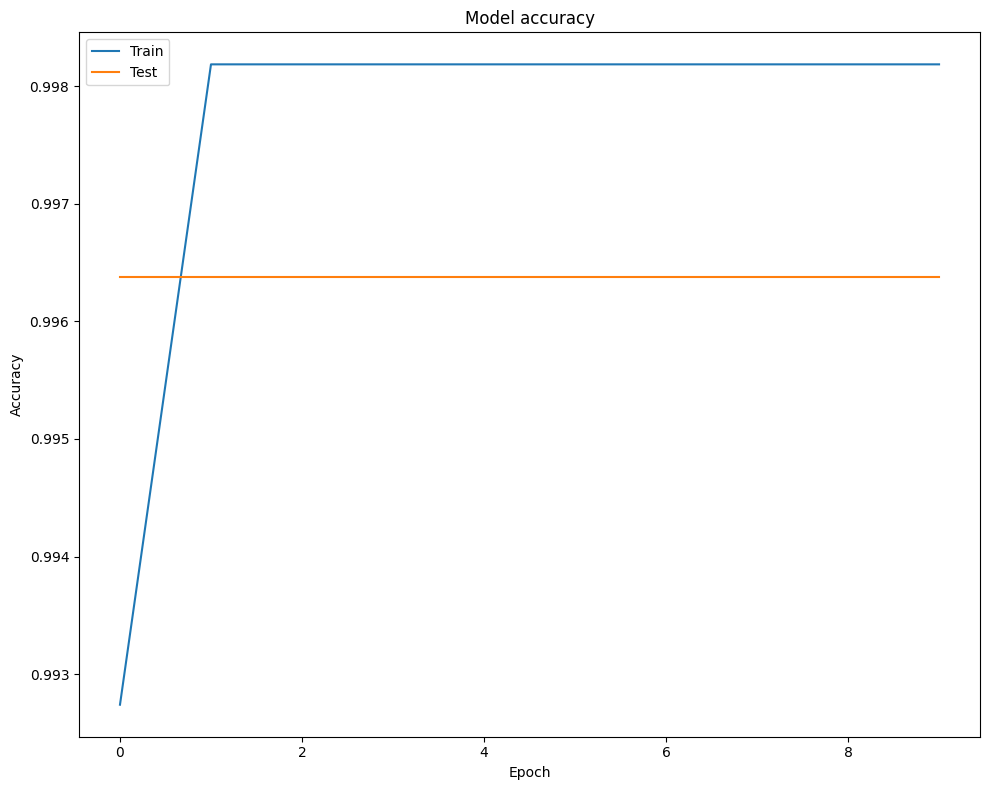

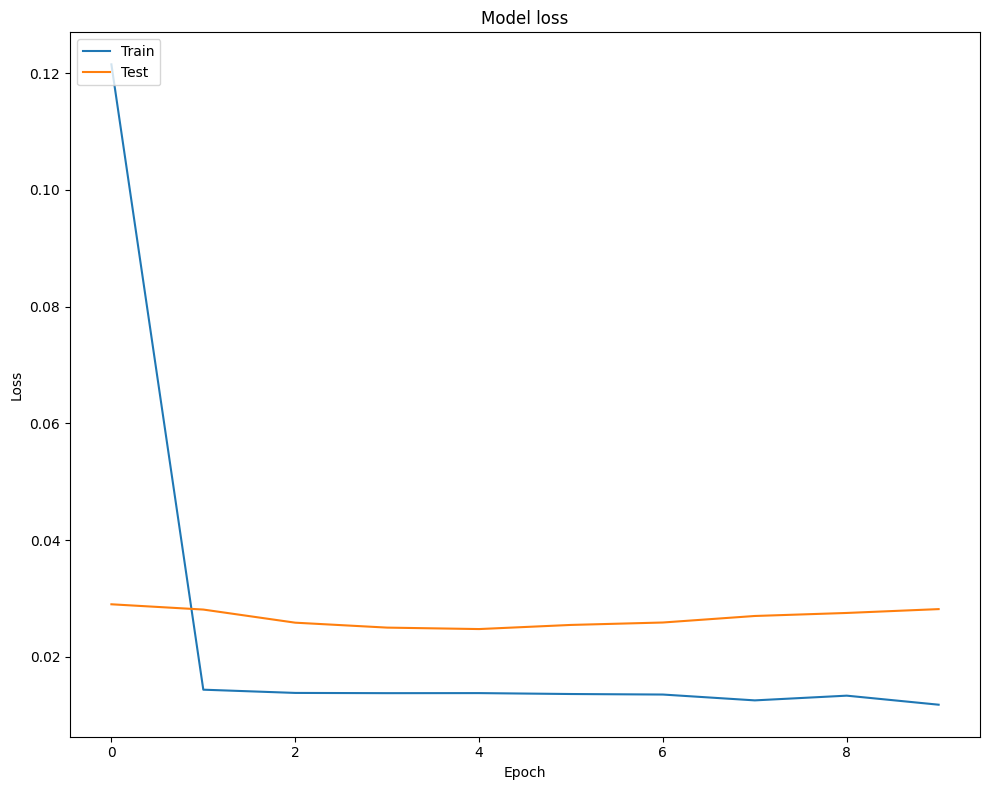

In [16]:
# Create the directories
os.makedirs('images/Recurrent Neural Network (RNN)', exist_ok=True)

# Plot training & validation accuracy values
plt.figure(figsize=(10, 8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.savefig('images/Recurrent Neural Network (RNN)/accuracy.png', dpi=600)
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.tight_layout()
plt.savefig('images/Recurrent Neural Network (RNN)/loss.png', dpi=600)
plt.show()

In [17]:
# Save the model
model_rnn.save('my_model.h5')

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
# Load the model
from keras.models import load_model
model = load_model('my_model.h5')

9/9 [==============================] - 13s 404ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       275
           1       1.00      0.00      0.00         1

    accuracy                           1.00       276
   macro avg       1.00      0.50      0.50       276
weighted avg       1.00      1.00      0.99       276

ROC AUC: 0.5


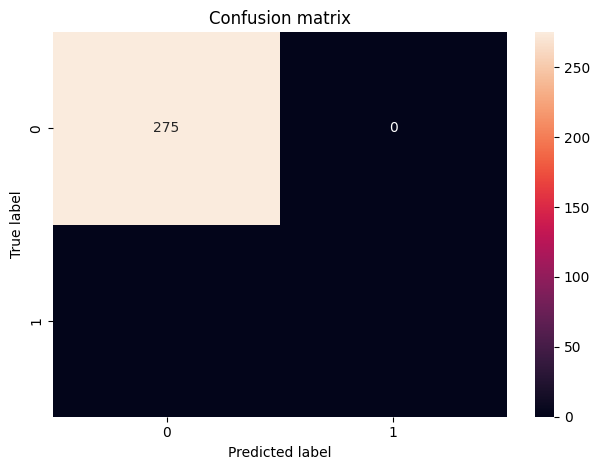

In [11]:
# X_test is the test data and y_test are the true labels
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convert probabilities to binary outputs

# Print the classification report
print(classification_report(y_test, y_pred, zero_division=1))

# Print the ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC AUC: {roc_auc}')

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()
plt.savefig('images/Recurrent Neural Network (RNN)/confusion_matrix.png', dpi=600)
plt.show()

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Create an array of IDs
ids = df['id'].values

# Split the IDs into training and test sets
_, ids_test = train_test_split(ids, test_size=0.2, random_state=42)

# Generate predictions
predictions = model.predict(X_test)

# If predictions is not a 1D array, flatten it
if predictions.ndim != 1:
    predictions = predictions.flatten()

# Define the file path
file_path = 'Data/sample_submission.csv'

# Load the existing DataFrame
submission_df = pd.read_csv(file_path)

# Keep only the headers
submission_df = submission_df[0:0]

# Add the new data
submission_df['id'] = ids_test
submission_df['generated'] = predictions

# Write the DataFrame back to the CSV file
submission_df.to_csv(file_path, index=False)

9/9 [==============================] - 2s 266ms/step


In [17]:

submission_df = pd.read_csv('Data/sample_submission.csv')

# Display the data
submission_df

,id,generated
0,70d7c567,0.000677
1,81977e6c,0.000649
2,e43869b8,0.000636
3,d33eca96,0.000643
4,71f7131e,0.001770
...,...,...
271,62b480e1,0.000679
272,7405b110,0.000664
273,47e743a7,0.000693
274,95d41c3e,0.000666
